In [2]:
print("Iniciando el script de analisis candidatos neutrones...")
print("Importando librerias necesarias...")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functions_spills
from scipy.optimize import curve_fit
from collections import defaultdict
import matplotlib.ticker as ticker

from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

Iniciando el script de analisis candidatos neutrones...
Importando librerias necesarias...


In [3]:
N_events = 157955
N_events_sig = 79586

In [4]:
# Leer el CSV
df = pd.read_csv('/scratch/cgarcia_2002/Complete_analysis/Neutron_candidates/neutron_candidates_22-30.csv')

# Asegurar tipos consistentes (por si event_number o start_time eran strings o enteros)
df['event_number'] = df['event_number'].astype(int)
df['start_time'] = df['start_time'].astype(float)

# Reconstruir el diccionario anidado
neutron_dict = defaultdict(lambda: defaultdict(list))

for _, row in df.iterrows():
    event_number = row['event_number']
    start_time = row['start_time']
    neutron_time = row['neutron_time']
    neutron_dict[event_number][start_time].append(neutron_time)

# Para neutron_dict
neutron_dict = {k: dict(v) for k, v in neutron_dict.items()}

In [5]:
df_sig = pd.read_csv('/scratch/cgarcia_2002/Complete_analysis/Neutron_candidates/neutron_candidates_sig_22-30.csv')

df_sig['event_number'] = df_sig['event_number'].astype(int)
df_sig['start_time'] = df_sig['start_time'].astype(float)

neutron_dict_sig = defaultdict(lambda: defaultdict(list))

for _, row in df_sig.iterrows():
    event_number = row['event_number']
    start_time = row['start_time']
    neutron_time = row['neutron_time']
    neutron_dict_sig[event_number][start_time].append(neutron_time)

# Para neutron_dict_sig
neutron_dict_sig = {k: dict(v) for k, v in neutron_dict_sig.items()}


In [6]:
deltaT = []
for event_number in neutron_dict:
    for start_time in neutron_dict[event_number]:
        neutron_times = neutron_dict[event_number][start_time]
        deltaT.append(min(neutron_times) - start_time)

deltaT_sig = []
for event_number in neutron_dict_sig:
    for start_time in neutron_dict_sig[event_number]:
        neutron_times = neutron_dict_sig[event_number][start_time]
        deltaT_sig.append(min(neutron_times) - start_time)



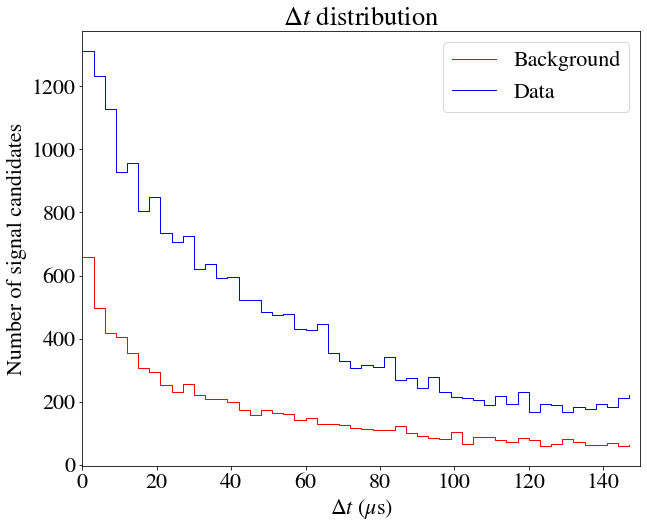

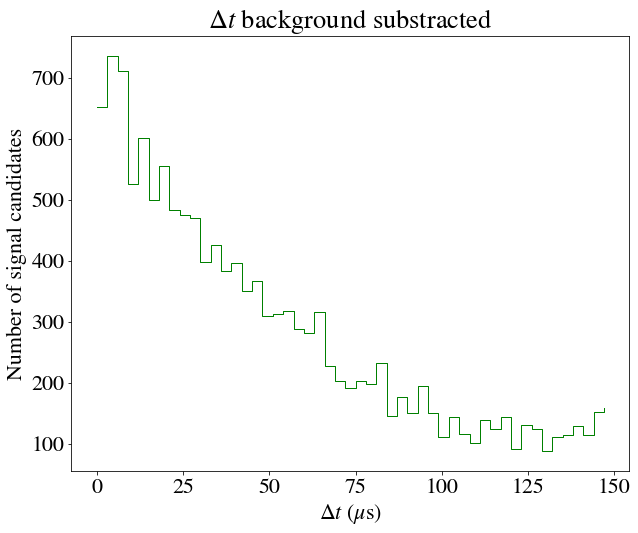

In [7]:
hist, bins_edges = np.histogram(deltaT, bins=50, range=(0, 150000))
hist_sig, _ = np.histogram(deltaT_sig, bins=bins_edges)

plt.figure()

plt.step(bins_edges[:-1], hist, where='post', linewidth=1, label='Background', color='red')
plt.step(bins_edges[:-1], hist_sig*N_events/N_events_sig, where='post', linewidth=1, label='Data', color='blue')
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ distribution')
plt.legend()
plt.xlim(0, 150000)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.savefig('/scratch/cgarcia_2002/Complete_analysis/Plots/DeltaT/DeltaT_Data.png', facecolor='white')

plt.figure()
plt.step(bins_edges[:-1], hist_sig*N_events/N_events_sig - hist, where='post', linewidth=1, color='green')
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ background substracted')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.savefig('/scratch/cgarcia_2002/Complete_analysis/Plots/DeltaT/DeltaT_BkgSubstraction.png', facecolor='white')


Ajuste: A = 1189.03, tau = 59939.17


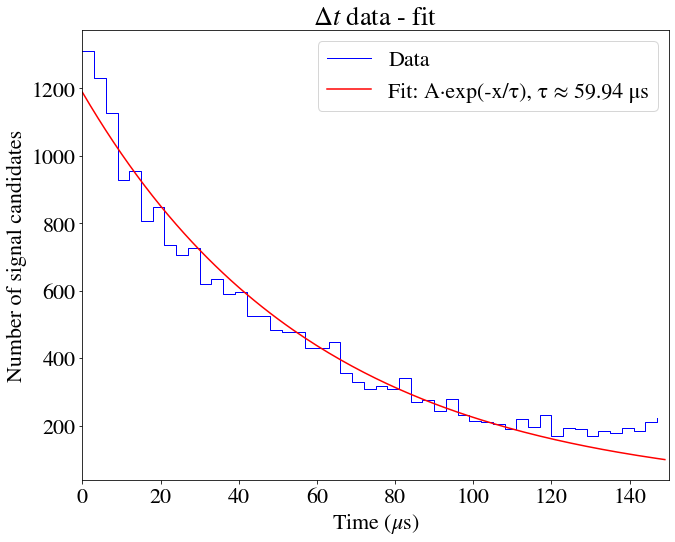

In [8]:
bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2  # calcular los centros de bin
data = hist_sig*N_events/N_events_sig

# 3. Definir la función exponencial para el ajuste
def exp_func(x, A, tau):
    return A * np.exp(-x / tau)

popt, pcov = curve_fit(exp_func, bin_centers, data, p0=(max(data), 500))

# popt contiene los parámetros A y tau
A_fit, tau_fit = popt
print(f"Ajuste: A = {A_fit:.2f}, tau = {tau_fit:.2f}")

# 5. (Opcional) Graficar el histograma y el ajuste
plt.figure()
plt.step(bins_edges[:-1], data, where='post', linewidth=1, label='Data', color='blue')
x_fit = np.arange(0, 150000, 1000)
plt.plot(x_fit, exp_func(x_fit, *popt), 'r-', label=f'Fit: A·exp(-x/τ), τ ≈ {tau_fit/1000:.2f} μs')
plt.xlabel(r'Time ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ data - fit')
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.xlim(0, 150000)
plt.savefig('/scratch/cgarcia_2002/Complete_analysis/Plots/DeltaT/DeltaT_FitData.png', facecolor='white')


Ajuste: A = 705.4156406474602, tau = 65833.5185068895


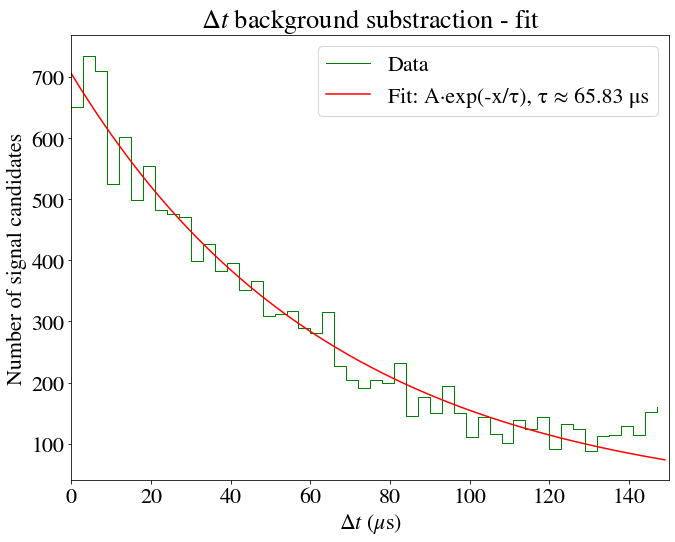

In [9]:
bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2  # calcular los centros de bin
data =  hist_sig*N_events/N_events_sig - hist

popt, pcov = curve_fit(exp_func, bin_centers, data, p0=(max(data), 500))

# popt contiene los parámetros A y tau
A_fit, tau_fit = popt
print(f"Ajuste: A = {A_fit}, tau = {tau_fit}")

plt.figure()
plt.step(bins_edges[:-1], data, where='post', linewidth=1, label='Data', color='green')
x_fit = np.arange(0, 150000, 1000)
plt.plot(x_fit, exp_func(x_fit, *popt), 'r-', label=f'Fit: A·exp(-x/τ), τ ≈ {tau_fit/1000:.2f} μs')
plt.xlabel(r'$\Delta t$ ($\mu$s)')
plt.ylabel('Number of signal candidates')
plt.title(r'$\Delta t$ background substraction - fit')
plt.legend()
plt.tight_layout()
plt.xlim(0, 150000)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1000:.0f}'))
plt.savefig('/scratch/cgarcia_2002/Complete_analysis/Plots/DeltaT/DeltaT_FitBkgSubstraction.png', facecolor='white')
